In [129]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import ast 
from collections import Counter
import itertools
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import community 
import numpy as np

In [130]:
data = pd.read_csv("../data/processed/notes_2024_fqdn_selected_with_classification.csv")
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn_selected"] = data["fqdn_selected"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)
data.head(3)

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected,summary_filtered,classification_result,classification_label,classification_score
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]",Trump posted on Truth Social on 12/30/2023 tha...,"[{'label': 'LABEL_2', 'score': 0.9998847246170...",LABEL_2,0.999885
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]",This has been refuted multiple times as false....,"[{'label': 'LABEL_2', 'score': 0.9996803998947...",LABEL_2,0.999680
2,"This story was updated, originally reporting t...",CURRENTLY_RATED_HELPFUL,1704126932804,2024-01-02,"[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","[www.politifact.com, www.npr.org]","This story was updated, originally reporting t...","[{'label': 'LABEL_0', 'score': 0.9895700216293...",LABEL_0,0.989570


In [131]:
bias_data = pd.read_csv("../data/processed/media_bias_score.csv")
helpful_data = pd.read_csv("../data/processed/helpful_score.csv")

## Network

In [132]:
domain_to_name = {
    'www.google.com': 'Google',
    'nypost.com': 'New York Post',
    'www.msn.com': 'MSN',
    'www.axios.com': 'Axios',
    'truthsocial.com': 'Truth Social',
    'thehill.com': 'The Hill',
    'www.dailymail.co.uk': 'Daily Mail',
    'x.com': 'X (formerly Twitter)',
    'www.foxnews.com': 'Fox News',
    'www.npr.org': 'NPR',
    'en.m.wikipedia.org': 'Wikipedia',
    'www.cnn.com': 'CNN',
    'www.cbsnews.com': 'CBS News',
    'www.nytimes.com': 'New York Times',
    'www.pbs.org': 'PBS',
    'www.washingtonpost.com': 'Washington Post',
    'www.whitehouse.gov': 'White House',
    'abcnews.go.com': 'ABC News',
    'www.usatoday.com': 'USA Today',
    'apnews.com': 'AP News',
    'www.nbcnews.com': 'NBC News',
    'www.newsweek.com': 'Newsweek',
    'www.politico.com': 'Politico',
    'www.forbes.com': 'Forbes',
    'www.bbc.com': 'BBC',
    'www.theguardian.com': 'The Guardian',
    'www.donaldjtrump.com': 'Donald J. Trump',
    'www.independent.co.uk': 'The Independent',
    'www.reuters.com': 'Reuters',
    'www.politifact.com': 'PolitiFact',
    'www.youtube.com': 'YouTube',
    'www.yahoo.com': 'Yahoo',
    'www.factcheck.org': 'FactCheck.org',
    'www.snopes.com': 'Snopes',
    'www.instagram.com': 'Instagram',
    'www.gettyimages.com': 'Getty Images',
}


In [133]:
# you can run this code only one time
bias_data = bias_data.rename(columns={"Unnamed: 0": "fqdn"})
helpful_data = helpful_data.rename(columns={"Unnamed: 0": "fqdn"})

bias_data = bias_data.set_index("fqdn")
helpful_data = helpful_data.set_index("fqdn")

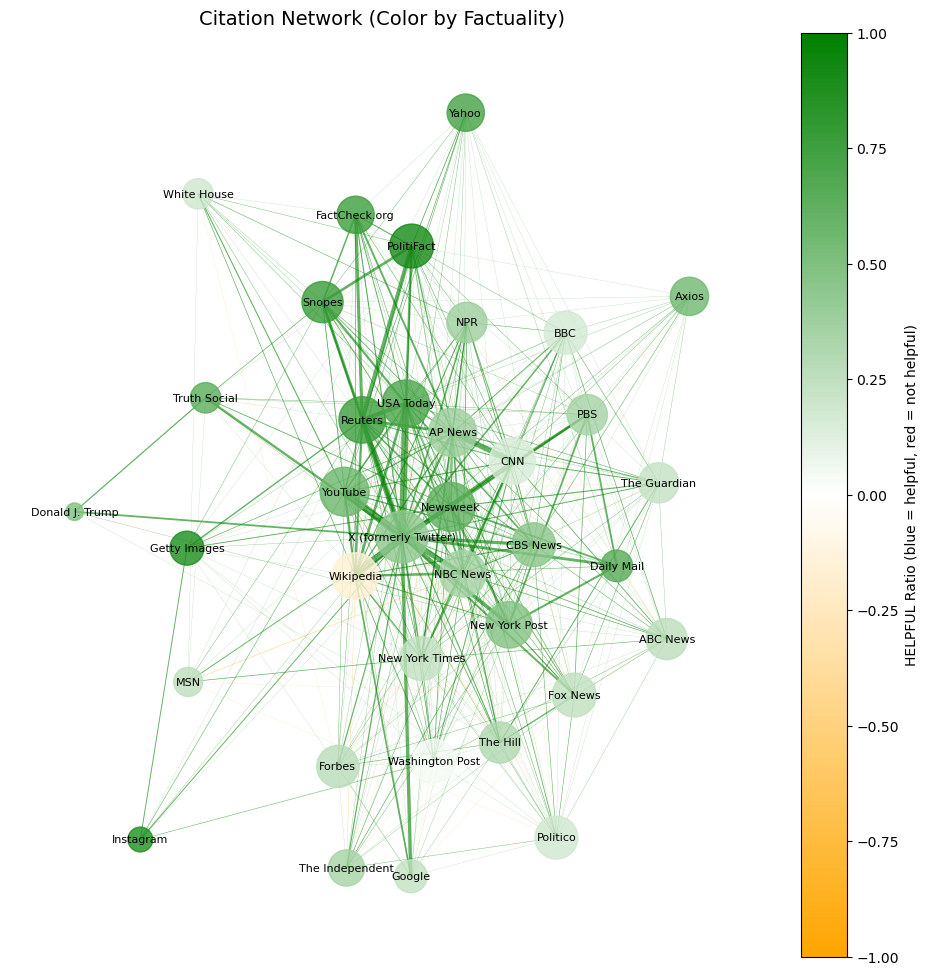

In [157]:
from matplotlib.colors import LinearSegmentedColormap
orange_green = LinearSegmentedColormap.from_list(
    "orange_green", ["orange", "white", "green"]
)

G = nx.Graph()
edge_weights = Counter()
edge_helpful_count = Counter()
edge_not_helpful_count = Counter()



for domain_list, status in zip(data["fqdn_selected"], data["currentStatus"]):

    for pair in combinations(domain_list, 2):
        edge = tuple(sorted(pair))
        edge_weights[edge] += 1
        if status == "CURRENTLY_RATED_HELPFUL":
            edge_helpful_count[edge] += 1
        elif status == "CURRENTLY_RATED_NOT_HELPFUL":
            edge_not_helpful_count[edge] += 1

for edge, weight in edge_weights.items():
    if edge[0] != edge[1]:  
        G.add_edge(*edge, weight=weight)

pos = nx.spring_layout(G, k=0.7, iterations=500, seed = 42)
node_size = [G.degree(n) * 40 for n in G.nodes]

labels = {node: domain_to_name.get(node, node) for node in G.nodes}

ratios = []
edges = list(G.edges)
for u, v in edges:
    edge = tuple(sorted((u, v)))
    helpful = edge_helpful_count[edge]
    not_helpful = edge_not_helpful_count[edge]
    total = helpful + not_helpful
    ratio = helpful - not_helpful/ total if total > 0 else 0
    ratios.append(ratio)

norm = mcolors.Normalize(vmin=-1, vmax=+1)

edge_colors = [orange_green(norm(r)) for r in ratios]
edge_widths = [G[u][v]['weight'] * 0.1 for u, v in edges]

norm_nodes = mcolors.Normalize(vmin=-1, vmax=1)

node_colors = []
for node in G.nodes:
    bias_value = helpful_data["mean"].get(node, 0) 
    color = orange_green(norm_nodes(bias_value))      
    node_colors.append(color)

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=0.8, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors, alpha=0.6)
nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=8)

sm = plt.cm.ScalarMappable(cmap=orange_green, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("HELPFUL Ratio (blue = helpful, red = not helpful)", fontsize=10)

ax.set_title("Citation Network (Color by Factuality)", fontsize=14)
ax.axis("off")
plt.savefig("../figure/figure3_1.pdf")
plt.show()

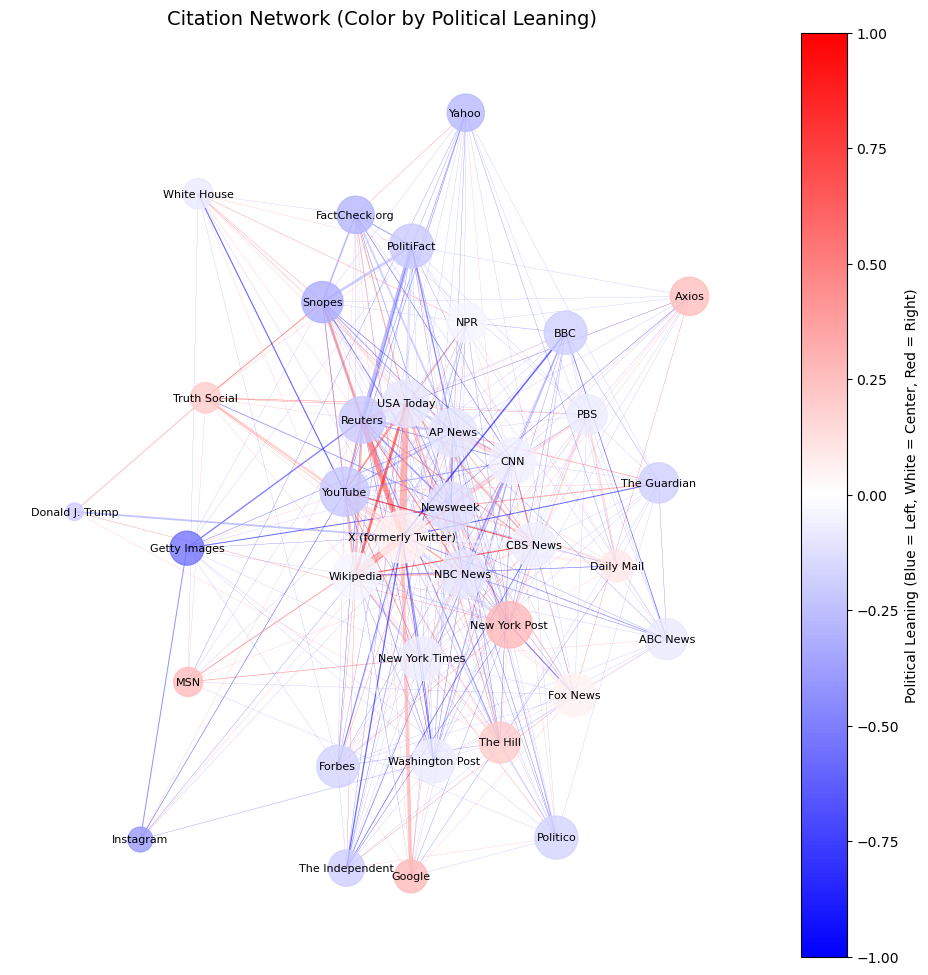

In [158]:
G = nx.Graph()
edge_weights = Counter()
edge_right_count = Counter()
edge_left_count = Counter()
edge_center_count = Counter()

# count edges and their weights
for domain_list, status in zip(data["fqdn_selected"], data["classification_label"]):
    for pair in combinations(domain_list, 2):
        edge = tuple(sorted(pair))
        edge_weights[edge] += 1
        if status == "LABEL_2":
            edge_right_count[edge] += 1
        elif status == "LABEL_1":
            edge_center_count[edge] += 1
        elif status == "LABEL_0":
            edge_left_count[edge] += 1


for edge, weight in edge_weights.items():
    if edge[0] != edge[1]:  
        G.add_edge(*edge, weight=weight)


pos = nx.spring_layout(G, k=0.7, iterations=500, seed = 42)
node_size = [G.degree(n) * 40 for n in G.nodes]

labels = {node: domain_to_name.get(node, node) for node in G.nodes}

edges = list(G.edges)
ratios = []
for u, v in edges:
    edge = tuple(sorted((u, v)))
    left = edge_left_count[edge]
    center = edge_center_count[edge]
    right = edge_right_count[edge]
    total = left + center + right

    if total > 0:
        # calculate media bias score
        ratio = (right - left) / total
        color_val = ratio 
    else:
        color_val = 0.5  
    ratios.append(color_val)

norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cm.bwr(norm(r)) for r in ratios]
edge_widths = [G[u][v]['weight'] * 0.1 for u, v in edges]


norm_nodes = mcolors.Normalize(vmin=-1, vmax=1)

node_colors = []
for node in G.nodes:
    bias_value = bias_data["mean"].get(node, 0) 
    color = cm.bwr(norm_nodes(bias_value))      
    node_colors.append(color)

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=0.8, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors, alpha=0.6)
nx.draw_networkx_labels(G, pos, ax=ax,labels = labels, font_size=8)

# color bar
sm = plt.cm.ScalarMappable(cmap=cm.bwr, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Political Leaning (Blue = Left, White = Center, Red = Right)", fontsize=10)

ax.set_title("Citation Network (Color by Political Leaning)", fontsize=14)
ax.axis("off")
plt.savefig("../figure/figure3_2.pdf")
plt.show()

## Clustering

In [105]:
# classify by louvain community detection
partition = community.best_partition(G)

louvain_community = pd.DataFrame(list(partition.items()), columns=['fqdn', 'label'])
louvain_community.sort_values("label").head()

,fqdn,label
2,truthsocial.com,0
30,www.instagram.com,0
25,www.whitehouse.gov,0
23,www.google.com,0
22,en.m.wikipedia.org,0


In [106]:
modularity = community.modularity(partition, G)
print(f"Modularity: {modularity}")

Modularity: 0.17712222832615954


### Measurement of media bias and helpful scores by communities

In [107]:
com_0 = ["x.com", "en.m.wikipedia.org", "www.youtube.com", "truthsocial.com", "www.whitehouse.gov", "www.google.com", "www.instagram.com", "www.donaldjtrump.com"]
com_1 = ["www.newsweek.com", "www.theguardian.com", "thehill.com", "nypost.com", "www.foxnews.com", "www.dailymail.co.uk", "www.pbs.org"]
com_2 = ["www.usatoday.com", "www.gettyimages.com", "www.factcheck.org", "www.politifact.com", "www.reuters.com", "www.yahoo.com", "www.snopes.com"]

com_all = com_0 + com_1 + com_2
com_all_set = set(com_all)
com_3 = [index for index in bias_data.index if index not in com_all_set]

com_0_bias = bias_data[bias_data.index.isin(com_0)].sum()
com_1_bias = bias_data[bias_data.index.isin(com_1)].sum()
com_2_bias = bias_data[bias_data.index.isin(com_2)].sum()
com_3_bias = bias_data[bias_data.index.isin(com_3)].sum()

com_0_helpful = helpful_data[helpful_data.index.isin(com_0)].sum()
com_1_helpful = helpful_data[helpful_data.index.isin(com_1)].sum()
com_2_helpful = helpful_data[helpful_data.index.isin(com_2)].sum()
com_3_helpful = helpful_data[helpful_data.index.isin(com_3)].sum()

community_bias = pd.DataFrame([com_0_bias, com_1_bias, com_2_bias, com_3_bias])[["Left", "Center", "Right", "total"]]
community_helpful = pd.DataFrame([com_0_helpful, com_1_helpful, com_2_helpful, com_3_helpful])[["helpful", "not_helpful", "total"]]


In [108]:
df = community_bias.copy()

def bootstrap_bias(row, n_boot=10000, ci=95, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    left, center, right = int(row["Left"]), int(row["Center"]), int(row["Right"])
    total = left + center + right  

    labels = np.concatenate([
        np.full(right,  1, dtype=np.int8),
        np.full(center, 0, dtype=np.int8),
        np.full(left,  -1, dtype=np.int8)
    ])

    samples = rng.choice(labels, size=(n_boot, total), replace=True)

    scores = samples.sum(axis=1) / total

    point_est = (right - left) / total

    alpha = 100 - ci
    lower = np.percentile(scores, alpha / 2)
    upper = np.percentile(scores, 100 - alpha / 2)

    return pd.Series({
        "mean": point_est,
        "ci_lower":  lower,
        "ci_upper": upper
    })

result_bias = df.apply(bootstrap_bias, axis=1)

result_bias


,mean,ci_lower,ci_upper
0,0.001040,-0.042642,0.043695
1,0.025090,-0.055556,0.105735
2,-0.225476,-0.294290,-0.153734
3,-0.068348,-0.122864,-0.014646


In [109]:
df = community_helpful.copy()

def bootstrap_bias(row, n_boot=10000, ci=95, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    helpful, not_helpful = int(row["helpful"]), int(row["not_helpful"])
    total = helpful + not_helpful  

    labels = np.concatenate([
        np.full(helpful,  1, dtype=np.int8),
        np.full(not_helpful,  -1, dtype=np.int8)
    ])

    samples = rng.choice(labels, size=(n_boot, total), replace=True)

    scores = samples.sum(axis=1) / total

    point_est = (helpful - not_helpful) / total

    alpha = 100 - ci
    lower = np.percentile(scores, alpha / 2)
    upper = np.percentile(scores, 100 - alpha / 2)

    return pd.Series({
        "mean": point_est,
        "ci_lower":  lower,
        "ci_upper": upper
    })

result_helpful = df.apply(bootstrap_bias, axis=1)

result_helpful


,mean,ci_lower,ci_upper
0,0.363114,0.315890,0.409062
1,0.441774,0.364140,0.515712
2,0.774436,0.726316,0.822556
3,0.287415,0.232993,0.341837


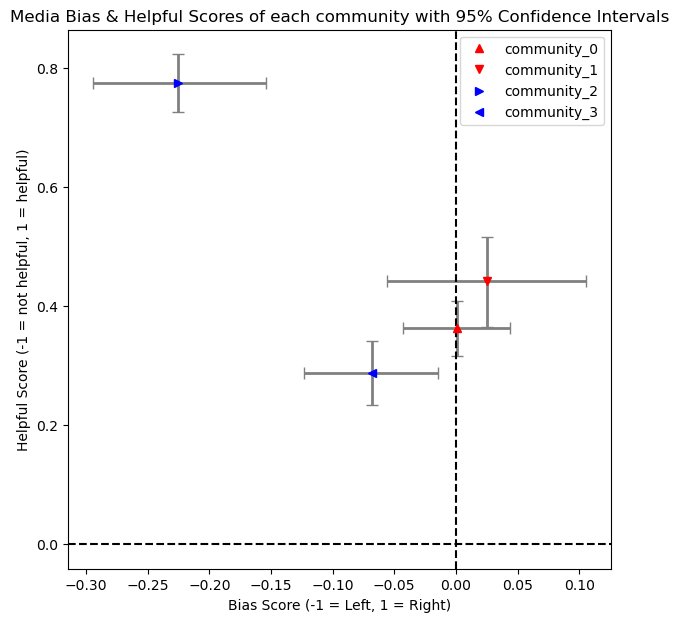

In [111]:
fig, ax = plt.subplots(figsize=(7,7))

fmt = ["^", "v", ">", "<"]

for i in range(4):
    media = f"community_{i}"
    media_bias = result_bias.iloc[i, 0]
    media_help = result_helpful.iloc[i, 0]
    upper_bias = result_bias.iloc[i, 2]
    lower_bias = result_bias.iloc[i, 1]
    upper_help = result_helpful.iloc[i, 2]
    lower_help = result_helpful.iloc[i, 1]
    color = "red" if media_bias > 0 else "blue"
    
    ax.errorbar(
        x = media_bias,
        y = media_help,
        xerr = [[media_bias - lower_bias], [upper_bias - media_bias]],
        yerr = [[media_help - lower_help], [upper_help - media_help]],
        fmt = fmt[i],
        c = color,
        ecolor = "gray",
        elinewidth=2,
        capsize=4
    )
    
    ax.plot([], [], fmt[i], label=media, c=color)  




ax.axvline(0, color='black', linestyle='--')
ax.axhline(0, color='black', linestyle='--')

plt.xlabel("Bias Score (-1 = Left, 1 = Right)")
plt.ylabel("Helpful Score (-1 = not helpful, 1 = helpful)")
plt.title("Media Bias & Helpful Scores of each community with 95% Confidence Intervals")
plt.legend()

plt.savefig("../figure/figure4.pdf")
plt.show()

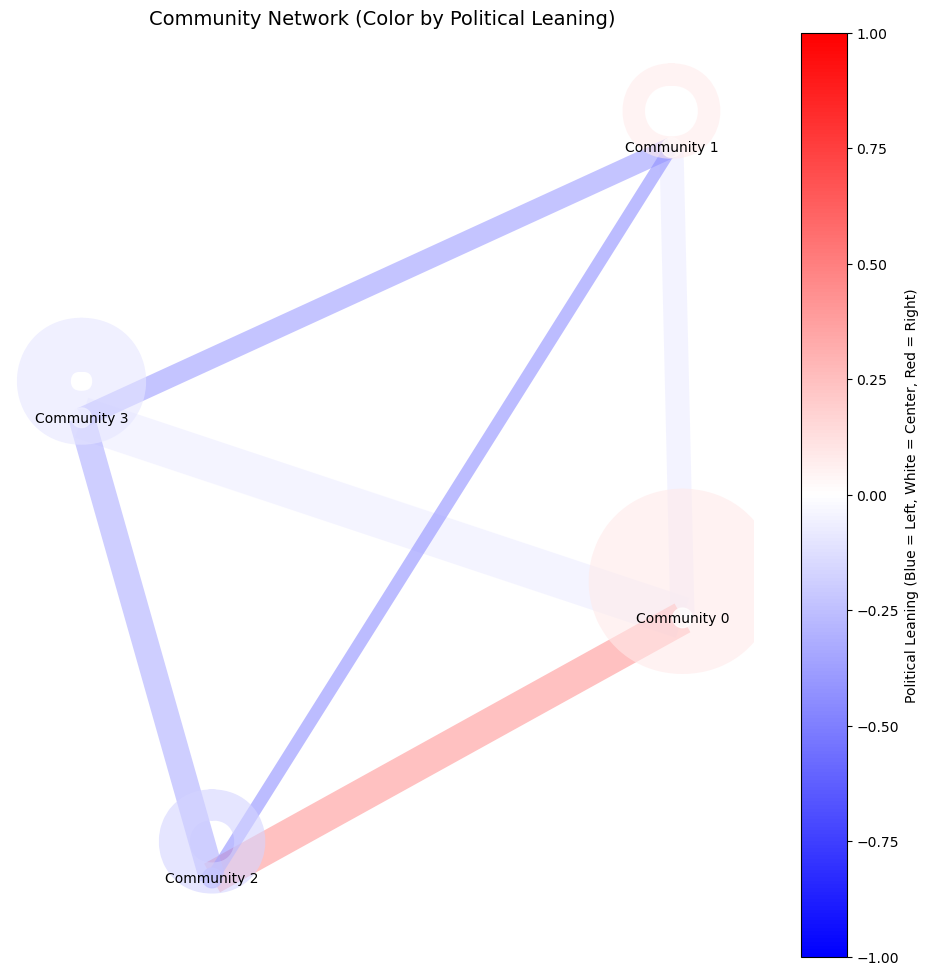

In [159]:
edge_weights = Counter()
edge_right_count = Counter()
edge_left_count = Counter()
edge_center_count = Counter()

for domain_list, status in zip(data["fqdn_selected"], data["classification_label"]):
    for pair in combinations(domain_list, 2):
        edge = tuple(sorted(pair))
        edge_weights[edge] += 1
        if status == "LABEL_2":
            edge_right_count[edge] += 1
        elif status == "LABEL_1":
            edge_center_count[edge] += 1
        elif status == "LABEL_0":
            edge_left_count[edge] += 1

com_edge_weights = Counter()
com_edge_right_count = Counter()
com_edge_left_count = Counter()
com_edge_center_count = Counter()

self_loops = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}
self_loop_left = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}
self_loop_center = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}
self_loop_right = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}

for edge, weight in edge_weights.items():
    com1 = None
    com2 = None
    for com, name in zip([com_0, com_1, com_2, com_3], ["com_0", "com_1", "com_2", "com_3"]):
        if edge[0] in com:
            com1 = name
        if edge[1] in com:
            com2 = name
    if com1 is None or com2 is None:
        continue
    if com1 == com2:
        self_loops[com1] += weight
        self_loop_left[com1] += edge_left_count[edge]
        self_loop_center[com1] += edge_center_count[edge]
        self_loop_right[com1] += edge_right_count[edge]
    else:
        key = tuple(sorted((com1, com2)))
        com_edge_weights[key] += weight
        com_edge_left_count[key] += edge_left_count[edge]
        com_edge_center_count[key] += edge_center_count[edge]
        com_edge_right_count[key] += edge_right_count[edge]

G = nx.Graph()
G.add_nodes_from(["com_0", "com_1", "com_2", "com_3"])

for edge, weight in com_edge_weights.items():
    G.add_edge(*edge, weight=weight)

# self loops
for com_name in self_loops:
    if self_loops[com_name] > 0:
        G.add_edge(com_name, com_name, weight=self_loops[com_name])


pos = nx.spring_layout(G, k=0.7, iterations=500, seed=42)
node_size = [G.degree(n) * 40 for n in G.nodes]
labels = {"com_0": "Community 0", "com_1": "Community 1", "com_2": "Community 2", "com_3": "Community 3"}

node_bias_score = {
    "com_0": result_bias["mean"].iloc[0],
    "com_1": result_bias["mean"].iloc[1],
    "com_2": result_bias["mean"].iloc[2],
    "com_3": result_bias["mean"].iloc[3]
}

# color map
norm = mcolors.Normalize(vmin=-1, vmax=1)

# node colors based on media bias score
node_colors = [cm.bwr(norm(node_bias_score[n])) for n in G.nodes]

edges = list(G.edges)
ratios = []
for u, v in edges:
    if u == v:  
        left = self_loop_left[u]
        center = self_loop_center[u]
        right = self_loop_right[u]
    else:
        key = tuple(sorted((u, v)))
        left = com_edge_left_count[key]
        center = com_edge_center_count[key]
        right = com_edge_right_count[key]

    total = left + center + right
    if total > 0:
        ratio = (right - left) / total
    else:
        ratio = 0  
    ratios.append(ratio)

norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cm.bwr(norm(r)) for r in ratios]
edge_widths = [G[u][v]['weight'] * 0.1 for u, v in edges]


fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=0.8, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors, alpha=0.6)
nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=10)

# color bar
sm = plt.cm.ScalarMappable(cmap=cm.bwr, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Political Leaning (Blue = Left, White = Center, Red = Right)", fontsize=10)

ax.set_title("Community Network (Color by Political Leaning)", fontsize=14)
ax.axis("off")
plt.savefig("../figure/figure5_2.pdf")
plt.show()

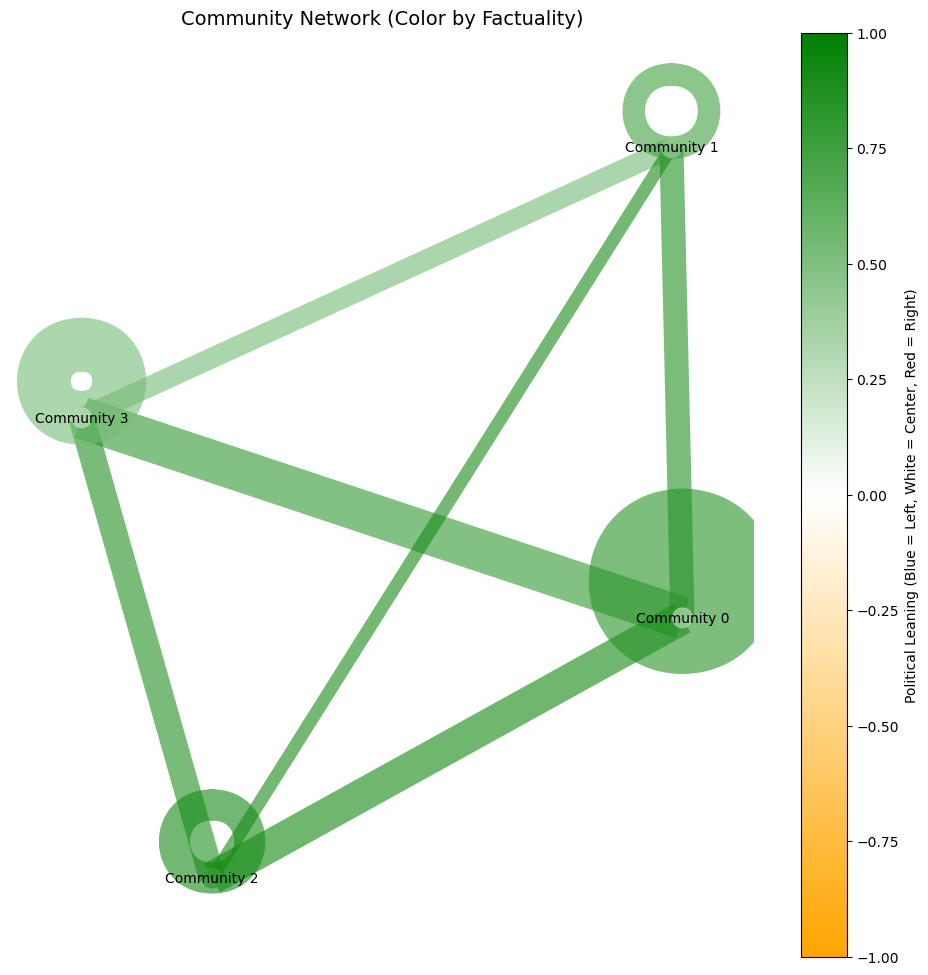

In [160]:
edge_weights = Counter()
edge_helpful_count = Counter()
edge_not_helpful_count = Counter()

for domain_list, status in zip(data["fqdn_selected"], data["currentStatus"]):
    for pair in combinations(domain_list, 2):
        edge = tuple(sorted(pair))
        edge_weights[edge] += 1
        if status == "CURRENTLY_RATED_HELPFUL":
            edge_helpful_count[edge] += 1
        elif status ==  "CURRENTLY_RATED_NOT_HELPFUL":
            edge_not_helpful_count[edge] += 1

com_edge_weights = Counter()
com_edge_helpful_count = Counter()
com_edge_not_helpful_count = Counter()

self_loops = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}
self_loop_helpful = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}
self_loop_not_helpful = {"com_0": 0, "com_1": 0, "com_2": 0, "com_3": 0}

for edge, weight in edge_weights.items():
    com1 = None
    com2 = None
    for com, name in zip([com_0, com_1, com_2, com_3], ["com_0", "com_1", "com_2", "com_3"]):
        if edge[0] in com:
            com1 = name
        if edge[1] in com:
            com2 = name
    if com1 is None or com2 is None:
        continue
    if com1 == com2:
        self_loops[com1] += weight
        self_loop_helpful[com1] += edge_helpful_count[edge]
        self_loop_not_helpful[com1] += edge_not_helpful_count[edge]
    else:
        key = tuple(sorted((com1, com2)))
        com_edge_weights[key] += weight
        com_edge_helpful_count[key] += edge_helpful_count[edge]
        com_edge_not_helpful_count[key] += edge_not_helpful_count[edge]


G = nx.Graph()
G.add_nodes_from(["com_0", "com_1", "com_2", "com_3"])

for edge, weight in com_edge_weights.items():
    G.add_edge(*edge, weight=weight)

# self loops
for com_name in self_loops:
    if self_loops[com_name] > 0:
        G.add_edge(com_name, com_name, weight=self_loops[com_name])


pos = nx.spring_layout(G, k=0.7, iterations=500, seed=42)
node_size = [G.degree(n) * 40 for n in G.nodes]
labels = {"com_0": "Community 0", "com_1": "Community 1", "com_2": "Community 2", "com_3": "Community 3"}

node_helpful_score = {
    "com_0": result_helpful["mean"].iloc[0],
    "com_1": result_helpful["mean"].iloc[1],
    "com_2": result_helpful["mean"].iloc[2],
    "com_3": result_helpful["mean"].iloc[3]
}

# color map
norm = mcolors.Normalize(vmin=-1, vmax=1)

# node colors based on media bias score
node_colors = [orange_green(norm(node_helpful_score[n])) for n in G.nodes]

edges = list(G.edges)
ratios = []
for u, v in edges:
    if u == v:  
        helpful = self_loop_helpful[u]
        not_helpful = self_loop_not_helpful[u]
    else:
        key = tuple(sorted((u, v)))
        helpful = com_edge_helpful_count[key]
        not_helpful = com_edge_not_helpful_count[key]
    total = helpful + not_helpful
    if total > 0:
        ratio = (helpful - not_helpful) / total
    else:
        ratio = 0  
    ratios.append(ratio)

norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [orange_green(norm(r)) for r in ratios]
edge_widths = [G[u][v]['weight'] * 0.1 for u, v in edges]


fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=0.8, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths, edge_color=edge_colors, alpha=0.6)
nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=10)

# color bar
sm = plt.cm.ScalarMappable(cmap=orange_green, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Political Leaning (Blue = Left, White = Center, Red = Right)", fontsize=10)

ax.set_title("Community Network (Color by Factuality)", fontsize=14)
ax.axis("off")
plt.savefig("../figure/figure5_1.pdf")
plt.show()